### 0. Drive settings, Imports and Control panel

In [1]:
# Check RAM Memory

from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('Not using a high-RAM runtime')
else:
  print('You are using a high-RAM runtime!')

print(ram_gb)

# Login into drive

from google.colab import drive
drive.mount('/content/drive')

Your runtime has 89.6 gigabytes of available RAM

You are using a high-RAM runtime!
89.63678208
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import glob
import json

import keras
import keras.backend as K
from keras.callbacks import EarlyStopping
from keras.models import Model
from keras.layers import Dense, Flatten, Input, Concatenate
from keras.regularizers import l2
from keras.applications.vgg16 import VGG16

import matplotlib
import matplotlib.pyplot as plt

import random
import skimage.io

import sklearn
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_auc_score
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold

import tensorflow as tf
import tensorflow.keras as keras
import tensorflow.keras.layers as layers
from keras.layers import concatenate
from torch.utils.data import Dataset , DataLoader

In [3]:
# Download and import data preprocessing .py file
!wget https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
from data_processing import data_bundle as data_bundle

# Download and import VGG16 .py file

# Download and import VGG16 .py file

--2023-05-13 16:57:06--  https://raw.githubusercontent.com/DiSanchz/satellite_imagery_econ_indicators/main/satellite_imagery_econ_indicators/data_processing.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3860 (3.8K) [text/plain]
Saving to: ‘data_processing.py.2’

data_processing.py. 100%[===================>]   3.77K  --.-KB/s    in 0s      

2023-05-13 16:57:06 (81.7 MB/s) - ‘data_processing.py.2’ saved [3860/3860]



In [4]:
# Define relevant paths for appropriately instantiating the data_bundle class
images_path_0 = "/content/drive/MyDrive/Thesis/imageset_500_500.npy"
popn_path_0 = "/content/drive/MyDrive/Thesis/siei_processed_v1.csv"
target_var = "gdp"

# In this case GDP has been chose
if target_var == "gdp":
  labels_path_0 = "/content/drive/MyDrive/Thesis/target_logGDP.npy"
  label_type = "GDPpercap"

elif target_var == "hdi":
  labels_path_0 = "/content/drive/MyDrive/Thesis/target_HDI.npy"
  label_type = "HDI"

# Instantiate data_bundle object
basic_bundle = data_bundle(images_path_0, popn_path_0, labels_path_0, label_type)

# Preprocess data through the data_bundle class' methods
basic_bundle.normalize_images()
basic_bundle.normalize_popn()
basic_bundle.bundle_inputs()
basic_bundle.split_data(0.4,0.5,2023)
basic_bundle.unbundle_and_shape_inputs()
basic_bundle.onehot_encode_labels()

# The resulting input sets are: self.X_tri, self.X_vai, self.X_tei (Images) and self.X_trp, self.X_vap, self.X_tep (Population)
# The resulting tragets are: self.y_train_onehot, self.y_val_onehot and self.y_test_onehot
# Where "self" is to be substituted by the given name to the data_bundle instance

/content/data_processing.py:32: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  features = np.array(list(zip(self.images, np.array(self.popn))))


### B. VGG16

In [5]:
# Import VGG16
vgg16_tl = VGG16(include_top=False, input_shape=(500, 500, 3))

# Freezing VGG16 layers
for layer in vgg16_tl.layers:
    layer.trainable = False

# Entry layer for instance population inputs
integer_input = Input(shape=(1,), name='integer_input')

# Flattening VGG16 output
image_features = layers.Flatten()(vgg16_tl.layers[-1].output)

# Merge VGG16 output with instance population
merged_inputs = Concatenate()([image_features, integer_input])

# Dense layers
dense_1 = layers.Dense(256, activation='relu')(merged_inputs)
dense_2 = layers.Dense(128, activation='relu')(dense_1)
dense_3 = layers.Dense(64, activation='relu')(dense_2)
dense_4 = layers.Dense(32, activation='relu')(dense_3)
dense_f = layers.Dense(16, activation='relu')(dense_4)

# Output layer 
output = layers.Dense(4, activation='softmax')(dense_f)

# Define new model
vgg16_merged_model = Model(inputs=[vgg16_tl.inputs, integer_input], outputs=output)

# Model summary
vgg16_merged_model.summary()

# Compile model
vgg16_merged_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Early stopping (Not working as expected)
es = EarlyStopping(monitor='val_accuracy', mode='max', patience=10,  restore_best_weights=True)

# Model fit
vgg_train = vgg16_merged_model.fit([basic_bundle.X_tri, basic_bundle.X_trp], basic_bundle.y_train_onehot, validation_data=([basic_bundle.X_vai, basic_bundle.X_vap], basic_bundle.y_val_onehot), batch_size=64 ,epochs=100, verbose=1, callbacks=es)

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 500, 500, 3  0           []                               
                                )]                                                                
                                                                                                  
 block1_conv1 (Conv2D)          (None, 500, 500, 64  1792        ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 block1_conv2 (Conv2D)          (None, 500, 500, 64  36928       ['block1_conv1[0][0]']           
                                )                                                             

In [11]:
import numpy as np

def plot_acc_loss(histo):
     ##Plot for the accuracy of the baseline model 
    accuracy_train = histo.history['accuracy']
    accuracy_val = histo.history['val_accuracy']
    plt.plot(accuracy_train, label='training_accuracy')
    plt.plot(accuracy_val, label='validation_accuracy')
    plt.title('ACCURACY OF THE MODEL')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()
    
    ##Plot for the loss of the baseline model 
    loss_train = histo.history['loss']
    loss_val = histo.history['val_loss']
    plt.plot(loss_train, label='training_loss')
    plt.plot(loss_val, label='validation_loss')
    plt.title('LOSS OF MODEL')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()
    return 

def plot_ROC_curve(y_predict,y_test,num_clas): 

    fpr = {}
    tpr = {}
    roc_auc = {}
    #calculating roc for each class
    for i in range(num_clas):
        fpr[i], tpr[i], _ = roc_curve(y_test[:,i], y_predict[:,i])
        roc_auc[i] = auc(fpr[i], tpr[i])
  
  # calculating micro-average ROC curve and  area
    fpr_micro, tpr_micro, _ = roc_curve(y_test.ravel(), y_predict.ravel())
    roc_auc_micro = roc_auc_score(y_test.ravel(), y_predict.ravel())

  # Compute macro-average ROC curve and  area
    fpr_macro = np.unique(np.concatenate([fpr[i] for i in range(num_clas)]))
    tpr_macro = np.zeros_like(fpr_macro)
    for i in range(num_clas):
        tpr_macro += np.interp(fpr_macro, fpr[i], tpr[i])
    tpr_macro /= num_clas
    roc_auc_macro = auc(fpr_macro, tpr_macro)

  #Plot the ROC curve for each class using matplotlib.pyplot.plot()
    plt.figure(figsize=(10, 5))
    lw = 2
    for i in range(num_clas):
        plt.plot(fpr[i], tpr[i], lw=lw, label='ROC curve of class %d (area = %0.2f)' % (i, roc_auc[i]))
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.plot(fpr_micro, tpr_micro,lw=lw, linestyle='--', label='micro-average ROC curve (area = %0.2f)' % (roc_auc_micro))
    plt.plot(fpr_macro, tpr_macro,lw=lw, linestyle='--', label='macro-average ROC curve (area = %0.2f)' % (roc_auc_macro))
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic of Multiclass')
    plt.legend(loc="lower right")
    plt.show()
    return 


def plot_cm(label_ma,y_predict,y_tes):
    #reversing pred to categorical so to get the labels 
    inverse_label_map = {v: k for k, v in label_ma.items()}  # invert the label_map
    y_pred_decoded_numerical = np.argmax(y_predict, axis=1)
    y_pred_decoded_categorical = np.vectorize(inverse_label_map.get)(y_pred_decoded_numerical)
    #confusion matrix 
    
    cm = confusion_matrix(y_tes, y_pred_decoded_categorical)
    classes = np.unique(y_tes)
    # plot the confusion matrix
    fig, ax = plt.subplots()
    im = ax.imshow(cm, interpolation='nearest', cmap='Reds')
    ax.figure.colorbar(im, ax=ax)
    ax.set(xticks=np.arange(cm.shape[1]), yticks=np.arange(cm.shape[0]), xticklabels=classes, yticklabels=classes, ylabel='True label',
             xlabel='Predicted label')

    # rotate the labels
    plt.setp(ax.get_xticklabels(), rotation=20, ha="right", rotation_mode="anchor")
    # text annotations like the numbers inside 
    thresh = cm.max() / 2.
    for i in range(cm.shape[0]):
      for j in range(cm.shape[1]):
          ax.text(j, i, format(cm[i, j], 'd'), ha="center", va="center", color="white" if cm[i, j] > thresh else "black")
    plt.show()
    return

def table_p_r_f1(y_tes,y_predict, label_ma):
  
    inverse_label_map = {v: k for k, v in label_ma.items()}  # invert the label_map
    y_pred_decoded_numerical = np.argmax(y_predict, axis=1)
    y_pred_decoded_categorical = np.vectorize(inverse_label_map.get)(y_pred_decoded_numerical)

    print(classification_report(y_test, y_pred_decoded_categorical))

def plot_comparison_acc_loss(models_compared,name_models, numepoch):
    epoch = range(1, numepoch+1)
    clr=['b','r','y','g','k','c']
    plt.figure(figsize=(10, 8))
    # Plotting the results of validation accuracy and loss for the baseline and tuned models
    plt.subplot(2, 2, 1)
    i=0
    while i<len(models_compared):
      plt.plot(epoch, models_compared[i].history['val_accuracy'], clr[i], label=name_models[i])
      i+=1
    plt.title('Validation accuracy comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    
    i=0
    plt.subplot(2, 2, 2)
    while i<len(models_compared):
      plt.plot(epoch, models_compared[i].history['val_loss'], clr[i], label=name_models[i])
      i+=1
    plt.title('Validation loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    
    i=0
    # Plotting the results of training accuracy and loss for the baseline and tuned models  
    plt.subplot(2, 2, 3)
    while i<len(models_compared):
      plt.plot(epoch, models_compared[i].history['accuracy'], clr[i], label=name_models[i])
      i+=1
    plt.title('Training accuracy comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()
    i=0
    plt.subplot(2, 2, 4)
    while i<len(models_compared):
      plt.plot(epoch, models_compared[i].history['loss'], clr[i], label=name_models[i])
      i+=1
    plt.title('Training loss comparison')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.subplots_adjust(hspace=0.4,wspace=0.4)
    plt.show()

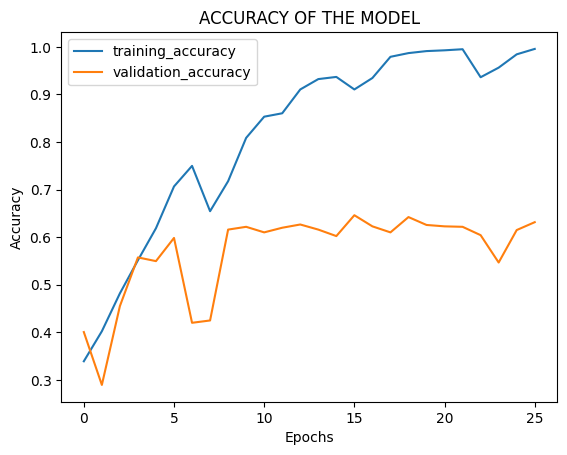

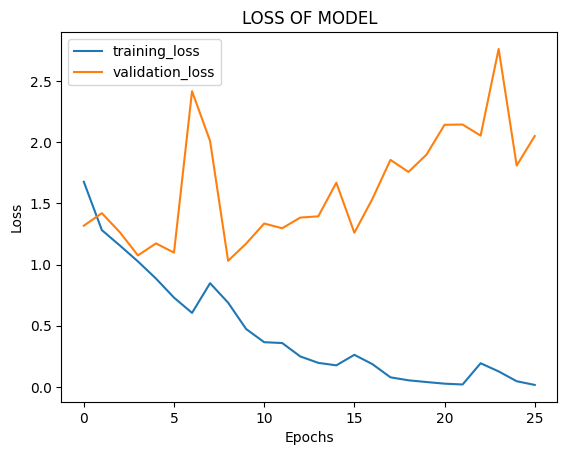

In [8]:
plot_acc_loss(vgg_train)

33/33 [==============================] - 3s 99ms/step


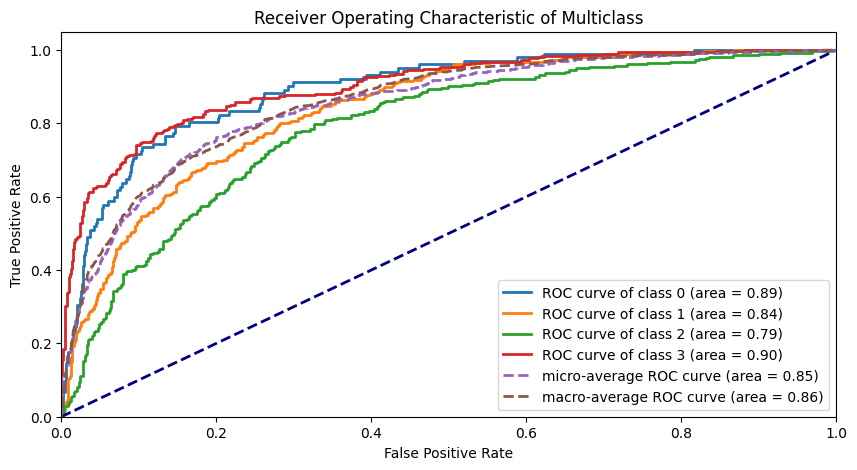

In [12]:
y_pred = vgg16_merged_model.predict([basic_bundle.X_tei, basic_bundle.X_tep])

plot_ROC_curve(y_pred,basic_bundle.y_test_onehot,4)

In [13]:
label_map = {"Quartile 1": 0, "Quartile 2": 1, "Quartile 3": 2, "Quartile 4": 3}

In [14]:
plot_cm(label_map,y_pred,basic_bundle.y_test_onehot)

# CM not working

ValueError: ignored

In [16]:
table_p_r_f1(basic_bundle.y_test_onehot,y_pred, label_map)

# not working, code needs to be adapted

NameError: ignored